#작사가를 쌈싸먹는 인공지능 작사가 만들기!

####이번에 진행하는 미니 프로젝트는 인공지능 작곡가 만들기이다.
####최근에 그림 그리는 인공지능도 나왔고 생각보다 인공지능이 여러업종에서 두각을 나타내고 있는 만큼
####이번 프로젝트도 충분히 가능하지 않을까란 생각이 든다.
####루브릭 평가 기준은 다음과 같다.


- 가사 텍스트 생성 모델이 정상적으로 동작하는가?

- 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?

- 텍스트 생성모델이 안정적으로 학습되었는가?

####개인적인 목표는 루브릭 평가기준을 충족함은 물론이고, 시각화와 모델을 발전 시키는 방향으로 진행할것이다.



#첫번째 모델 만들기!

##구글 드라이브 임포트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##경로설정 후 압축풀기 진행

In [ ]:
%cd "/content/drive/MyDrive/pic/ex"
!unzip "archive.zip"

/content/drive/MyDrive/pic/ex
Archive:  archive.zip
  inflating: Kanye_West.txt          
  inflating: Lil_Wayne.txt           
  inflating: adele.txt               
  inflating: al-green.txt            
  inflating: alicia-keys.txt         
  inflating: amy-winehouse.txt       
  inflating: beatles.txt             
  inflating: bieber.txt              
  inflating: bjork.txt               
  inflating: blink-182.txt           
  inflating: bob-dylan.txt           
  inflating: bob-marley.txt          
  inflating: britney-spears.txt      
  inflating: bruce-springsteen.txt   
  inflating: bruno-mars.txt          
  inflating: cake.txt                
  inflating: dickinson.txt           
  inflating: disney.txt              
  inflating: dj-khaled.txt           
  inflating: dolly-parton.txt        
  inflating: dr-seuss.txt            
  inflating: drake.txt               
  inflating: eminem.txt              
  inflating: janisjoplin.txt         
  inflating: jimi-hendrix.txt       

####노래가사 데이터는 캐글에서 다운받았다.
####실습 노드에서 진행한 것과 똑같은 데이터이다.
####우선 처음에는 베이직한 모델을 만들것이으로, 데이터를 더는 추가하지 않고 해보겠다.

##데이터 적재

In [ ]:
import glob
import os
import warnings
warnings.filterwarnings("ignore")

path = '/content/drive/MyDrive/pic/ex/*'
txt_list_1 = glob.glob(path) #경로 지정

raw_corpus_1 = [] #가사를 담을 리스트

for txt_file in txt_list_1:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() #가사를 한줄씩 읽음
        raw_corpus_1.extend(raw) #가사를 리스트에 저장
        
print("데이터 크기:", len(raw_corpus_1))
print("Examples:\n", raw_corpus_1[:5])

데이터 크기: 187088
Examples:
 ['\ufeffEighteen years eighteen years', 'She got one of your kids got you for eighteen years', 'I know somebody paying child support for one of his kids', 'His baby mama car and crib is bigger than his', 'You will see him on TV any given Sunday']


####데이터 적재를 끝내고 코드를 실행한 결과
####크기는 187088개와 리스트를 5개 출력해본 결과 문장들이 출력된다면
####데이터 적재를 올바르게 시킨게 맞다.

##중복 파일 제거

In [ ]:
def check_duplicate_lyrics(file1, file2):
    txt1 = []
    txt2 = []

    with open(file1, "r", encoding="utf-8") as f: #파일하나를 읽어본다
        raw = f.read().splitlines()
        txt1.extend(raw) #내용 한줄씩 저장
    with open(file2, "r" ,encoding="utf-8") as f: #파일하나를 읽어본다
        raw = f.read().splitlines()
        txt2.extend(raw) #내용 한줄씩 저장    
    txt1 = set(txt1) #txt1에서 중복을 제거
    txt2 = set(txt2) #txt2에서 중복을 제거
    diff = txt1.difference(txt2) #다른 가사만 변수에 넣기
    return len(txt1) * 0.05 > len(diff) 

import itertools
for a, b in itertools.combinations(txt_list_1, 2):
    if check_duplicate_lyrics(a, b): #가사가 95% 일치하는지
        print(a, b)
        txt_list_1.remove(b) #일치한다면 제거

/content/drive/MyDrive/pic/ex/Kanye_West.txt /content/drive/MyDrive/pic/ex/kanye-west.txt
/content/drive/MyDrive/pic/ex/notorious-big.txt /content/drive/MyDrive/pic/ex/notorious_big.txt


####컴퓨터에 쓴 코드가 2개의 중복을 찾았고 그 파일을 제거한걸로 볼 수 있다.
####이제 다음단계로 넘어가도록 하자

##세밀한 데이터 분석과 시각화에 도전해보자

In [ ]:
import pandas as pd

df = pd.DataFrame({'Lyrics' : raw_corpus_1[:5],
                   'num' : [n for n in range(1, 6)]})
df.set_index('num', inplace = True)
df

,Lyrics
num,
1,﻿Eighteen years eighteen years
2,She got one of your kids got you for eighteen ...
3,I know somebody paying child support for one o...
4,His baby mama car and crib is bigger than his
5,You will see him on TV any given Sunday


####중복을 제거한 데이터를 판다스로 확인하던중 의문이 생겼다.
####과연 이 데이터들은 어떤 단어를 가장 많이 내포하고 있을까?
####또한, 어떤식으로 토큰화가 이루어지는도 의문이었다.
####그래서 데이터 전처리와 시각화를 진행해보겠다.

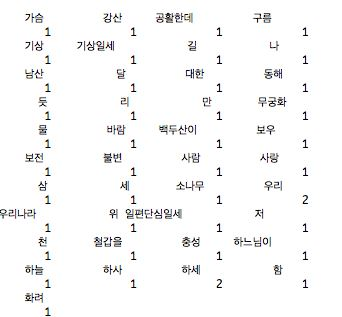

####요런식으로 확인하고 싶었다.

In [1]:
import numpy as np
#사이킷런에서 지원해주는 토큰화 모델 사용
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
cv = CountVectorizer() #공백으로 텍스트를 나눔, 한글은 따로 처리가 필요함
tdm = cv.fit_transform(raw_corpus_1)
tdm.shape

(187088, 27968)

####공백으로 토큰화를 진행 시키기 총 27968개가 나왔다.
####너무 많다는 생각이 들어 갯수를 조금 줄이겠다.

In [ ]:
cv1 = CountVectorizer(max_features = 1000, stop_words = 'english') #단어 갯수를 1000개로 제한, 분석에 필요없는 조사와 같은 부분제거
tdm1 = cv1.fit_transform(raw_corpus_1)
tdm1.shape

(187088, 1000)

####1000개의 데이터만 확인해보도록 하자.
####그리고 이곳에서 확인할건 어떤 단어가 많이 쓰인지라는 부분이다.
####그래서 조사와 같은 불필요한 부분은 제거하겠다.

In [ ]:
word = cv1.get_feature_names()
print(word[:5])

['act', 'afraid', 'ago', 'ah', 'ahead']


####텍스트를 공백 기준으로 분리 후 불필요한 부분을 제거하고 5개를 출력해보았다.
####잘 나누어진것을 확인해볼수있다.
####그럼 각각의 단어가 총 몇개 있는지도 확인해보자.

In [ ]:
tdm1

<187088x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 399905 stored elements in Compressed Sparse Row format>

In [ ]:
count = tdm1[:].toarray()
print(count)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


####1000개의 단어를 불러온 tdm1을 확인해보니 단어 문서 행렬이 대부분 값이 0으로 되어있다.
####zip써서 단어와 숫자로 합쳐보자

In [ ]:
word_count = list(zip(word, count))
print(word_count[:3])

[('act', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

####결과는 생각보다 처참했다.
####값들이 다 따로따로 출력이 되버리니 어지럽게 보인다.
####그럼 sum으로 합치면 어떻게 진행되는지 보자

In [ ]:
count1 = tdm1.sum(axis=0)
word_count1 = list(zip(word, count1))
word_count1[:10]

[('act', matrix([[ 312,  217,   98,  790,  133, 2673, 1168,  328,  383,  644,
            102,  105,  150,  105,  138,  166,  162,  219,   92,  349,
            542,  152, 1017,   94, 1611,  260,  139,  441, 5367, 1331,
            250,  197,  138,  196,  137,  483,  395,   92,  441,  118,
            106,  881,  100,   98,  146,  818,  223, 1409, 1206,  460,
            124,  111,  154,  220, 1693,  686,  104,  681,  194,  113,
            129,  227,  290,  419,  425,  134,  165,  868,  101,  193,
            336,  157,  237,  144,   96,  234,  112,  773,   97,  134,
           1339,  411,  188,  179,  558,  174,  168,  161,  241,  554,
            299,  301,  264,  116,  176,  108,  202,  248,  136,  173,
            193,   92,  362,  134,  132,  126,  226,  163,  203,  733,
            376,  607,  157,  172,   97,  215,  138,  247,  232, 3829,
            133,  113,  289,  487,  122,  123,  359,  121,  270,  270,
            236,  107,  780,  126,  107,  403,  116,  136,  133,   93,

####그저 마음이 아팠다.
####출력값을 보자 뭔가 이상한게 보인다 분명히 생각했던건 "문자":숫자(1차원) 였는데
####2차원으로 표시가 된거 같다.
####그럼 1차원으로 줄이는 코드를 추가해서 실행해보겠다.

In [ ]:
count2 = tdm1.sum(axis=0)
word_count2 = list(zip(word, count2.flat)) #flat을 써서 1차원으로 만들어 줌
word_count2[:10]

[('act', 312),
 ('afraid', 217),
 ('ago', 98),
 ('ah', 790),
 ('ahead', 133),
 ('ain', 2673),
 ('aint', 1168),
 ('air', 328),
 ('alive', 383),
 ('alright', 644)]

####드디어 제대로 출력이 되었다.
####이번에는 보기 편하게 데이터 프레임화 시켜보겠다.

In [ ]:
word_count2 = sorted(word_count2, key = lambda x:x[1], reverse = True)
df = pd.DataFrame(word_count2, columns = ['word', 'word_num'])
df

,word,word_num
0,like,9772
1,love,7614
2,know,7592
3,just,7484
4,don,7423
...,...,...
995,pants,92
996,proud,92
997,sat,92
998,speed,92


####이렇게 만들어보니 위에서 진행한 코드보다 보기가 편하고 어떤 단어를 많이 썻는지
####눈에 확 들어온다.
####이제 시각화를 진행해보자.

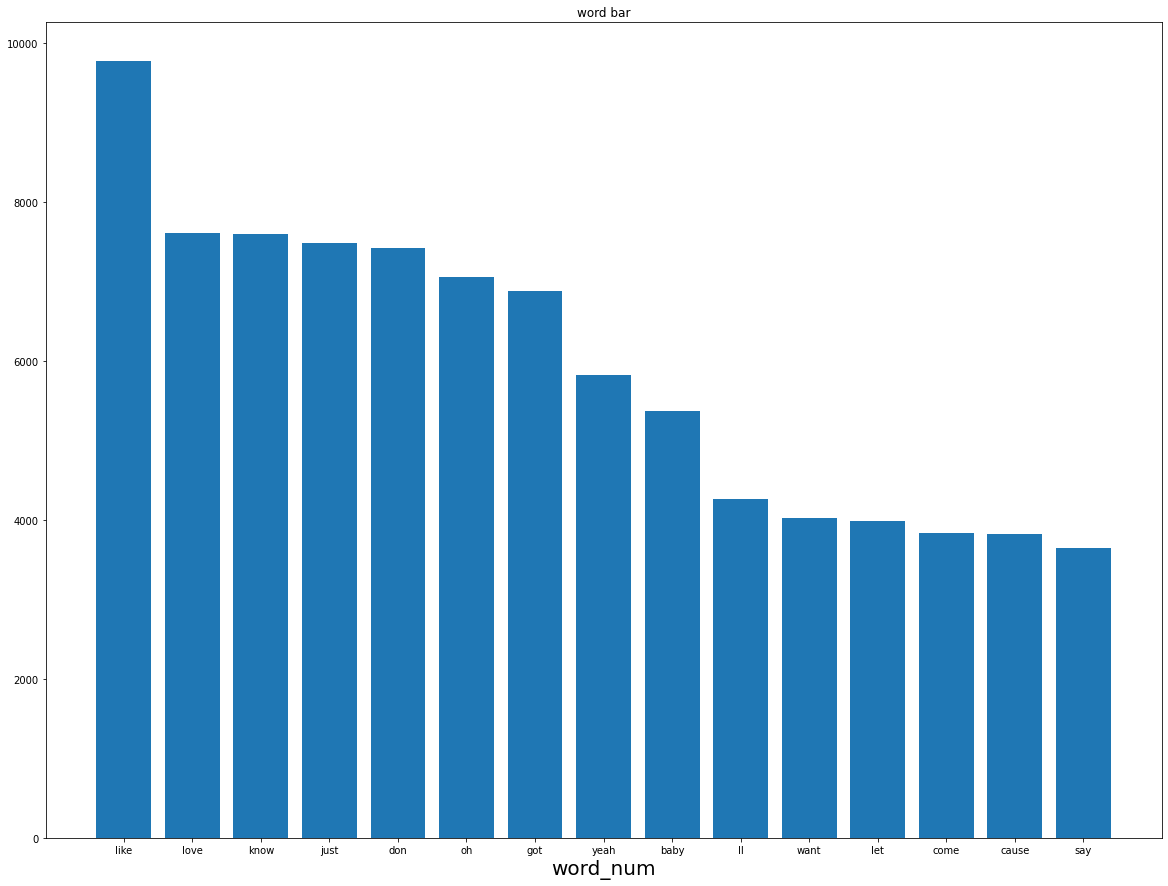

In [ ]:
import matplotlib.pyplot as plt

x_df = df[:15]

plt.figure(figsize=(20,15))
plt.bar(x_df['word'], x_df['word_num'])
plt.title('word bar')
plt.xlabel('word', fontsize = 20)
plt.xlabel('word_num', fontsize = 20)
plt.show()

####눈으로 확인하니 더 잘 들어오는거 같다.

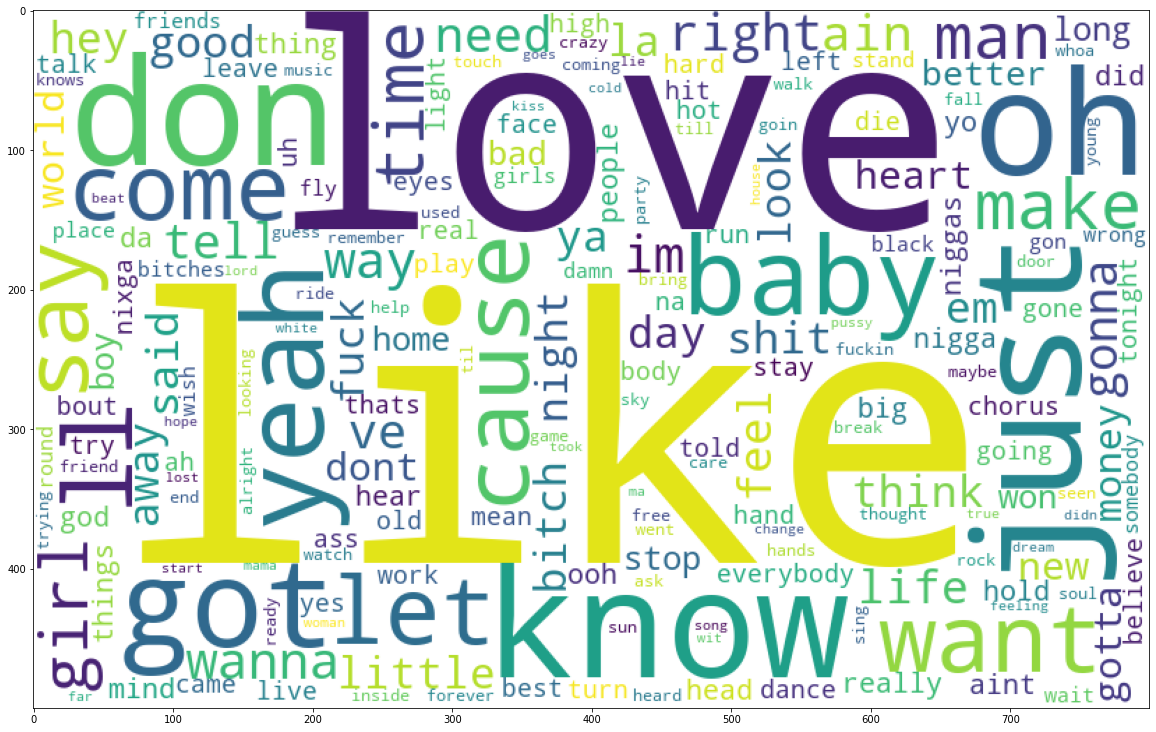

In [ ]:
from wordcloud import WordCloud

wc = WordCloud(background_color = 'white', width = 800, height = 500)
cloud = wc.fit_words(dict(word_count2))
plt.figure(figsize=(20,15))
plt.imshow(cloud)

####그리고 자연어는 wordcloud라는게 존재한다.
####출력을 해보면 단어 빈도수에 따라서 크기로 표현이 되는거 같다.


##문장을 정리하여 데이터 정제

In [ ]:
import re

#정규표현식을 사용하여 문장들을 처리
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    sen1 = sentence.split(' ')

#갯수가 14개 이하의 문장들만 추려낸다.
    if len(sen1) >= 14: 
        return 0
    else:
        sentence = '<start> ' + sentence + ' <end>'
        return sentence
        
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


####왜 갯수가 14개인 문장들만 추려내는가 하면
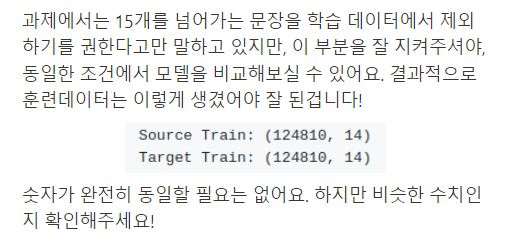
####조건에도 나와있고, 노션 페이지 -> 프로젝트 노드 제출관련을 보게되면
####위의 사진처럼 조건이 나와있는걸 확인가능하다. 

In [ ]:
'''corpus = []

for sentence in raw_corpus_1:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
corpus[:10]'''

####위에 코드는 문장이 0개인 것도 포함시킬수 있다고 생각하여 쓰지않았다.
####물론 그럴 확률은 적겠지만 만약을 생각해서 그런 부분도 있을수 있기에 밑에 코드로 실행하겠다.

In [ ]:
corpus = []

for sentence in raw_corpus_1:
    if len(sentence) == 0: 
      continue
    if sentence[-1] == ":": 
      continue

    preprocessed_sentence = preprocess_sentence(sentence)
    if preprocessed_sentence == 0:
        pass
    else:
        corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> eighteen years eighteen years <end>',
 '<start> she got one of your kids got you for eighteen years <end>',
 '<start> i know somebody paying child support for one of his kids <end>',
 '<start> his baby mama car and crib is bigger than his <end>',
 '<start> you will see him on tv any given sunday <end>',
 '<start> win the super bowl and drive off in a hyundai <end>',
 '<start> she was supposed to buy your shorty tyco with your money <end>',
 '<start> she went to the doctor got lipo with your money <end>',
 '<start> she walking around looking like michael with your money <end>',
 '<start> shouldve got that insured geico for your money <end>']

In [ ]:
df1 = pd.DataFrame({'Lyrics' : raw_corpus_1[:10],
                   'num' : [n for n in range(1, 11)]})
df1.set_index('num', inplace = True)
df1

,Lyrics
num,
1,﻿Eighteen years eighteen years
2,She got one of your kids got you for eighteen ...
3,I know somebody paying child support for one o...
4,His baby mama car and crib is bigger than his
5,You will see him on TV any given Sunday
6,Win the Super Bowl and drive off in a Hyundai
7,She was supposed to buy your shorty Tyco with ...
8,She went to the doctor got lipo with your money
9,She walking around looking like Michael with y...


####생각한대로 잘 들어간거같다.
####아니 잘 들어간게 확실하다.
####이제 이 데이터를 잘 이용하여 모델을 만들러 가보자

##데이터 토큰화

In [ ]:
import tensorflow as tf

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words = 17000,  # 단어장 크기는 17000개
        filters = ' ',
        oov_token = "<unk>" #담기지 않은 단어는 unk로 통일
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  #padding으로 공백 추가
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2 2421  433 ...    0    0    0]
 [   2   44   37 ...    3    0    0]
 [   2    4   34 ...    3    0    0]
 ...
 [   2   21   77 ...    0    0    0]
 [   2   41   26 ...    0    0    0]
 [   2   21   77 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f06f0f52a50>


####17000개의 단어장을 사용하여 토큰화를 시켰다.
####그 다음 값을 출력해보았는데, 숫자들로 잘 이루어진걸 볼 수 있다.

In [ ]:
print(tensor.shape)
print(tensor[:8, :14])

(156013, 15)
[[   2 2421  433 2421  433    3    0    0    0    0    0    0    0    0]
 [   2   44   37   59   20   19  531   37    7   28 2421  433    3    0]
 [   2    4   34  246 2491  542 3069   28   59   20   99  531    3    0]
 [   2   99   52  338  434    8 1065   26 1652  166   99    3    0    0]
 [   2    7   84   63  144   18 1153  364 1217 1038    3    0    0    0]
 [   2  649    6 1519 3070    8  570  117   14    9 7665    3    0    0]
 [   2   44   53  848   10  463   19 1429 7666   30   19  140    3    0]
 [   2   44  279   10    6 1318   37 8635   30   19  140    3    0    0]]


####8개의 문장들을 확인해본결과
####2로 시작하는걸 확인할 수 있고 뒤는 3을 제외하면 다 0인걸 볼 수 있다.
####여기서 0은 패딩으로 생각한다.
####그럼 3은 무엇일까?
####확인 해보자

In [ ]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 14: 
      break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to
11 : it
12 : me
13 : my
14 : in




```
    if len(sen1) >= 14: 
        return 0
    else:
        sentence = '<start> ' + sentence + ' <end>'
        return sentence
```
####위에 정의한 코드에서 이런 부분이 있었다.
####즉, 2로 시작하는것은 start으로 3은 end여서 저기서 문장이 끝난걸 의미한다.
####0000인걸 패딩을 추가해주면서 문장 길이를 맞추기위해 들어간걸로 확인된다.


##학습용 평가용 데이터 분리

In [ ]:
#마지막 토큰을 잘라 문장을 완성 마지막 토큰은 0(<pad>)일 확률이 높음
src_input = tensor[:, :-1]
#첫번째 토큰을 잘라 문장 생성
tgt_input = tensor[:, 1:]
  
print(src_input[0])
print(tgt_input[0])

[   2 2421  433 2421  433    3    0    0    0    0    0    0    0    0]
[2421  433 2421  433    3    0    0    0    0    0    0    0    0    0]


####소스문장과 타겟문장을 생성하는 과정이다. 
####위의 과정을 통해 문장내에 뒷 단어를 label로 가지게된다.
####즉, 정답이 있는 문제에 대해 확률값을 구하는 
####방식으로 다음에 올 단어를 유추해볼 수 있다.

In [ ]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=42)

####train_test_split을 사용하여 노드에 나와있는 8:2비율로 데이터를 나누어준다.

In [ ]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

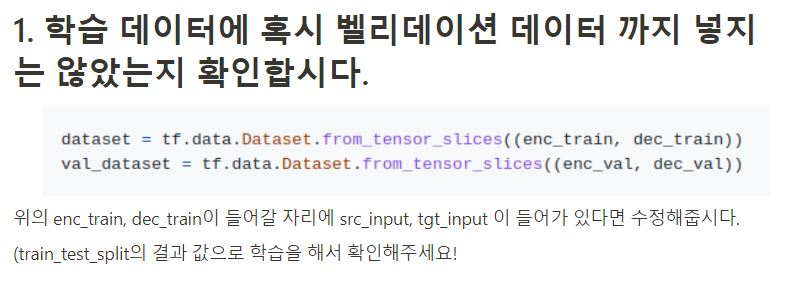

####수행 조건에 맞게 제대로 수행한거 같다.

In [ ]:
print("enc_train:", enc_train.shape)
print("enc_val", enc_val.shape)
print("dec_train:", dec_train.shape)
print("dec_val:", dec_val.shape)

enc_train: (124810, 14)
enc_val (31203, 14)
dec_train: (124810, 14)
dec_val: (31203, 14)


####두번째 숫자가 딱 14로 맞춰진다면, 여기까지 문제없이 잘 되고 있다는 뜻이다.

##모델 정의 및 학습!

In [ ]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 512
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

####모델을 정의한다.
####처음에는 기본 모델에서 임베딩 사이즈와 히든 사이즈만 변경해서 돌려보겠다.

In [ ]:
#배치하나를 가지고 온다.
for src_sample, tgt_sample in dataset.take(1): 
  break
#모델에 가지고온 배치를 넣는다.
model(src_sample)

<tf.Tensor: shape=(256, 14, 17001), dtype=float32, numpy=
array([[[-2.4162962e-04,  3.3711072e-04, -4.5330358e-05, ...,
          1.4785196e-04, -7.6445824e-05,  2.1647975e-04],
        [ 3.2527998e-04,  2.5947037e-04,  3.7351849e-05, ...,
          6.8469642e-05,  8.0251702e-05,  3.7825727e-04],
        [ 6.5971300e-04,  6.8138388e-04,  9.4730443e-05, ...,
          1.2228102e-04,  2.8126326e-05,  6.2620029e-04],
        ...,
        [ 1.4106828e-03, -2.2121159e-05, -4.6766919e-04, ...,
         -6.9928169e-04, -1.3364189e-04, -4.1915249e-04],
        [ 1.5803804e-03,  5.3633205e-05, -4.5091109e-04, ...,
         -7.9382909e-04, -2.5041820e-04, -3.9049133e-04],
        [ 1.4910694e-03,  1.7903959e-04, -4.8335496e-04, ...,
         -9.7014842e-04, -4.6603847e-04, -6.8550544e-05]],

       [[-2.4162962e-04,  3.3711072e-04, -4.5330358e-05, ...,
          1.4785196e-04, -7.6445824e-05,  2.1647975e-04],
        [-4.0243796e-04,  5.7635753e-04, -2.5618265e-05, ...,
          1.3394370e-04, 

####출력값을 보게되면 (256, 14, 17001)로 나오는데 첫번째는 배치사이즈를 의미한다.
####두번째는 단어의 길이, 세번째는 단어장 갯수이다.
####알맞게 잘 나오는 것을 확인할 수 있다.


In [ ]:
model.summary()

Model: "text_generator_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  8704512   
                                                                 
 lstm_2 (LSTM)               multiple                  20979712  
                                                                 
 lstm_3 (LSTM)               multiple                  33562624  
                                                                 
 dense_1 (Dense)             multiple                  34835049  
                                                                 
Total params: 98,081,897
Trainable params: 98,081,897
Non-trainable params: 0
_________________________________________________________________


####summary로 모델 정보를 확인해준다.
####파라미터가 9천만개인걸 볼 수 있다.

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

model = model.fit(dataset, validation_data = (enc_val,dec_val), epochs = 10) 

Epoch 1/10
487/487 [==============================] - 154s 311ms/step - loss: 3.4269 - val_loss: 3.0706
Epoch 2/10
487/487 [==============================] - 152s 311ms/step - loss: 2.9172 - val_loss: 2.8551
Epoch 3/10
487/487 [==============================] - 151s 310ms/step - loss: 2.6837 - val_loss: 2.7127
Epoch 4/10
487/487 [==============================] - 153s 313ms/step - loss: 2.4800 - val_loss: 2.6072
Epoch 5/10
487/487 [==============================] - 150s 309ms/step - loss: 2.2950 - val_loss: 2.5220
Epoch 6/10
487/487 [==============================] - 150s 308ms/step - loss: 2.1231 - val_loss: 2.4582
Epoch 7/10
487/487 [==============================] - 171s 351ms/step - loss: 1.9614 - val_loss: 2.4032
Epoch 8/10
487/487 [==============================] - 150s 309ms/step - loss: 1.8076 - val_loss: 2.3587
Epoch 9/10
487/487 [==============================] - 171s 352ms/step - loss: 1.6615 - val_loss: 2.3226
Epoch 10/10
487/487 [==============================] - 150s 308m

####또 마음이 아파왔다.
####평가 기준이 val_loss값이 2.2 이하로 나와야한다.
####하지만 2.3이 나와버렸다.. 

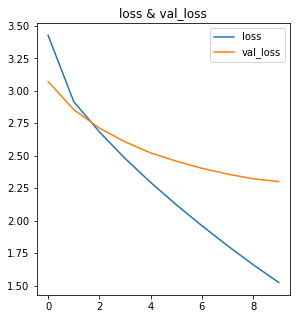

In [ ]:
plt.figure(figsize=(10, 5))

# 에포크별 loss값
plt.subplot(1,2,2)
plt.plot(model.history["loss"], label="loss")
plt.plot(model.history["val_loss"], label="val_loss")
plt.title("loss & val_loss")
plt.legend()

plt.show()

####loos값은 잘 떨어지고 있지만 val_loss는 떨어지는 속도가 더뎌보인다.
####혹시 중복을 제거함으로써 데이터에 크기가 작아진게 문제가 아닐까?
####한번 중복 제거를 하지않고 실행해보겠다.

---

#두번째 모델 만들기!

##압축풀기

In [ ]:
%cd "/content/drive/MyDrive/pic/ex"
!unzip "archive.zip"

/content/drive/MyDrive/pic/ex
Archive:  archive.zip
  inflating: Kanye_West.txt          
  inflating: Lil_Wayne.txt           
  inflating: adele.txt               
  inflating: al-green.txt            
  inflating: alicia-keys.txt         
  inflating: amy-winehouse.txt       
  inflating: beatles.txt             
  inflating: bieber.txt              
  inflating: bjork.txt               
  inflating: blink-182.txt           
  inflating: bob-dylan.txt           
  inflating: bob-marley.txt          
  inflating: britney-spears.txt      
  inflating: bruce-springsteen.txt   
  inflating: bruno-mars.txt          
  inflating: cake.txt                
  inflating: dickinson.txt           
  inflating: disney.txt              
  inflating: dj-khaled.txt           
  inflating: dolly-parton.txt        
  inflating: dr-seuss.txt            
  inflating: drake.txt               
  inflating: eminem.txt              
  inflating: janisjoplin.txt         
  inflating: jimi-hendrix.txt       

####런타임을 초기화 시킨다음에 파일을 지우고 처음부터 다시 실행했다.

##두번째 데이터 정제

In [ ]:
import glob
import os

path = '/content/drive/MyDrive/pic/ex/*'
txt_list_1 = glob.glob(path)

raw_corpus_1 = [] #가사 담을 리스트 정의

for txt_file in txt_list_1:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() 
        raw_corpus_1.extend(raw) #가사 한 줄씩 저장 
        
print("데이터 크기:", len(raw_corpus_1)) #187088 파일 제거하기 전 데이터 크기 
print("Examples:\n", raw_corpus_1[:5])

데이터 크기: 187088
Examples:
 ['\ufeffEighteen years eighteen years', 'She got one of your kids got you for eighteen years', 'I know somebody paying child support for one of his kids', 'His baby mama car and crib is bigger than his', 'You will see him on TV any given Sunday']


####출력값은 당연히 첫번째 모델 만들기와 동일한걸 볼 수 있다.

##문장을 정리하여 데이터 정제

In [ ]:
import re

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    sen1 = sentence.split(' ')

    if len(sen1) >= 14: 
        return 0
    else:
        sentence = '<start> ' + sentence + ' <end>'
        return sentence
        
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


####이 부분도 마찬가지다.
####바로 모델을 정의하고 학습까지 가보도록 하자.

In [ ]:
corpus = []

for sentence in raw_corpus_1:
    if len(sentence) == 0: 
      continue
    if sentence[-1] == ":": 
      continue

    preprocessed_sentence = preprocess_sentence(sentence)
    if preprocessed_sentence == 0:
        pass
    else:
        corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> eighteen years eighteen years <end>',
 '<start> she got one of your kids got you for eighteen years <end>',
 '<start> i know somebody paying child support for one of his kids <end>',
 '<start> his baby mama car and crib is bigger than his <end>',
 '<start> you will see him on tv any given sunday <end>',
 '<start> win the super bowl and drive off in a hyundai <end>',
 '<start> she was supposed to buy your shorty tyco with your money <end>',
 '<start> she went to the doctor got lipo with your money <end>',
 '<start> she walking around looking like michael with your money <end>',
 '<start> shouldve got that insured geico for your money <end>']

##데이터 토큰화

In [ ]:
import tensorflow as tf

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words = 18000, 
        filters = ' ',
        oov_token = "<unk>"
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2 2421  433 ...    0    0    0]
 [   2   44   37 ...    3    0    0]
 [   2    4   34 ...    3    0    0]
 ...
 [   2   21   77 ...    0    0    0]
 [   2   41   26 ...    0    0    0]
 [   2   21   77 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f31f71592d0>


In [ ]:
print(tensor.shape)
print(tensor[:8, :14])

(156013, 15)
[[   2 2421  433 2421  433    3    0    0    0    0    0    0    0    0]
 [   2   44   37   59   20   19  531   37    7   28 2421  433    3    0]
 [   2    4   34  246 2491  542 3069   28   59   20   99  531    3    0]
 [   2   99   52  338  434    8 1065   26 1652  166   99    3    0    0]
 [   2    7   84   63  144   18 1153  364 1217 1038    3    0    0    0]
 [   2  649    6 1519 3070    8  570  117   14    9 7665    3    0    0]
 [   2   44   53  848   10  463   19 1429 7666   30   19  140    3    0]
 [   2   44  279   10    6 1318   37 8635   30   19  140    3    0    0]]


##학습용 평가용 데이터 분리

In [ ]:
src_input = tensor[:, :-1]
tgt_input = tensor[:, 1:]
  
print(src_input[0])
print(tgt_input[0])

[   2 2421  433 2421  433    3    0    0    0    0    0    0    0    0]
[2421  433 2421  433    3    0    0    0    0    0    0    0    0    0]


In [ ]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=42)

In [ ]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

##두번째 모델 정의 및 학습!

In [ ]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 1024
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

####배치 사이즈를 512에 두배로 한번 늘려봤다.

In [ ]:
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 18001), dtype=float32, numpy=
array([[[ 9.78602257e-05, -2.88051553e-04, -1.06282263e-04, ...,
          2.44786406e-05, -2.28000543e-04,  2.40375681e-04],
        [-9.14713601e-05, -2.81031971e-05, -4.90168459e-04, ...,
          2.93496909e-04,  3.27115325e-04,  1.25844890e-04],
        [-2.44072624e-04,  1.93706495e-04, -4.86676407e-04, ...,
          2.41945978e-04,  5.40471927e-04, -7.09324013e-05],
        ...,
        [ 1.29024743e-03, -1.54211171e-04, -4.41706832e-03, ...,
          1.06937403e-03,  8.73571495e-04, -6.50757225e-03],
        [ 1.23750034e-03,  1.40175007e-06, -4.66931798e-03, ...,
          1.06746377e-03,  9.04733257e-04, -6.87037874e-03],
        [ 1.14696613e-03,  1.58854178e-04, -4.86975163e-03, ...,
          1.04837096e-03,  9.23197367e-04, -7.16421893e-03]],

       [[ 9.78602257e-05, -2.88051553e-04, -1.06282263e-04, ...,
          2.44786406e-05, -2.28000543e-04,  2.40375681e-04],
        [ 9.82756410e-06, -7.88681034e-04, -1

In [ ]:
model.summary()

Model: "text_generator_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  18433024  
                                                                 
 lstm_6 (LSTM)               multiple                  25174016  
                                                                 
 lstm_7 (LSTM)               multiple                  33562624  
                                                                 
 dense_3 (Dense)             multiple                  36884049  
                                                                 
Total params: 114,053,713
Trainable params: 114,053,713
Non-trainable params: 0
_________________________________________________________________


####이번에는 파라미터가 1억개인걸 확인할 수 있다.
####데이터 중복을 제거하지 않았고 배치사이즈를 늘렸기 때문인거 같다.

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


model.compile(loss=loss, optimizer=optimizer)

In [ ]:
from keras.callbacks import EarlyStopping

stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
model.fit(dataset, validation_data = (enc_val,dec_val), epochs = 8, callbacks = [stop])

Epoch 1/8
487/487 [==============================] - 161s 326ms/step - loss: 3.4233 - val_loss: 3.0043
Epoch 2/8
487/487 [==============================] - 158s 325ms/step - loss: 2.8081 - val_loss: 2.7285
Epoch 3/8
487/487 [==============================] - 158s 325ms/step - loss: 2.4660 - val_loss: 2.5379
Epoch 4/8
487/487 [==============================] - 158s 325ms/step - loss: 2.1435 - val_loss: 2.3996
Epoch 5/8
487/487 [==============================] - 158s 325ms/step - loss: 1.8508 - val_loss: 2.3012
Epoch 6/8
487/487 [==============================] - 158s 325ms/step - loss: 1.5953 - val_loss: 2.2360
Epoch 7/8
487/487 [==============================] - 158s 325ms/step - loss: 1.3834 - val_loss: 2.2007
Epoch 8/8
487/487 [==============================] - 158s 325ms/step - loss: 1.2176 - val_loss: 2.1929


####겨우 루브릭 통과기준에 맞춘걸 확인할 수 있다.
####좀처럼 떨어지지 않길래 걱정을 많이 했는데 잘된거 같아서 다행이다.

##모델 결과 출력!

In [ ]:
#입력받은것을 텐서로 변환
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

#한 단어씩 예측해 문장 생성
    while True:
        predict = model(test_tensor) 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]
        #예측된 값을 문장 뒤에 붙이기 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        #모델이 <end>를 예측했으면 문장 생성을 종료
        if predict_word.numpy()[0] == end_token:
          break

    generated = ""

    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> you ", max_len=20)

'<start> you know you re right <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> love ", max_len=20)

'<start> love is all you need to purchase all the merchandise <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> dog ", max_len=20)

'<start> dog won t bite pig <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> change ", max_len=20)

'<start> change my way of thinking , make myself a different set of rules <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> dream ", max_len=20)

'<start> dream of the moon <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> moon ", max_len=20)

'<start> moon is over me <end> '

###몇개의 문장을 출력해보았는데 상당히 중2병스럽지만, 자연스러운 문장으로 출력되었다.

---

#마치며
####크게 실습노드와 다른점은 크기를 14로 제한한다거나 데이터셋을 
####enc_train, enc_val, dec_train, dec_val 나눠서 학습시키는거 같다.
####크기 제한을 없애면서 enc_train, enc_val, dec_train, dec_val로 데이터를 나누지 않으면, 
####loss값은 더욱 폭발적으로 줄어든다.
####이번노드를 보면서 리미트와 제한을 상당히 잘 걸었다고 생각했다.
####여러가지 방법을 생각하기에 좋았다(배치사이즈를 바꾼게 다지만...)
####마지막으로 자연어 시각화 부분은 상당히 유익했던거 같았다.
####어려운 점도 않았다. 
####단어별로 나누는것, 배열을 합치고 다 더해주는것 등등 쓰고 싶은게 많았고(클레스터, t_sne 등등)
####시도는 해보았지만, 결과는 좋지 못하였다.(실력 부족..)
####아쉬운 점은 레이어를 늘려 학습을 시키지 못한 점이다.
####모델 학습이 이렇게까지 오래 걸릴줄은 생각을 못했다.
####물론 데이터량이 상당히 많기는 하였지만, 텍스트라 빨리 끝날줄 생각한게 오산이었다.
####학습 환경을 gpu로 바꾸는걸 잃어버리고 실행했을때 결과는 끔찍했다.(중간에 알아차려서 다행이다)
####나중에 따로 공부를해서 완전 새로운 방식으로 다시 만들어보고 싶다. 



---

####참고자료
https://github.com/alwaysmindy/aiffel_exploration/blob/fdad316dfea47d0a5e9b130cd98e181334fef738/exploration3_lstm_lyrics.ipynb


https://www.kaggle.com/code/anandhuh/word-cloud-in-python-for-beginners

https://jtoday.tistory.com/83